# Homework 2 (66 pts)

## Overview
This homework will focus on checking the global and local spatial autocorrelation and point pattern analysis based on the Airbnb listing in New York City and the underlying socioeconomics. Through this practice, you will review the process of retrieving data from API, building spatial weights from georeferenced data, checking global and local spatial autocorrelation, and conducting point pattern analysis. 

## Grading
Each exercise will be graded based on the following rubrics:
- 2 points. Completed the task, presented the expected results, and codes were well documented and explained.
- 1 point. Completed the task with some disparity from the expected results.
- 0 point. Did not complete the excercise.

## Late submission policy
For late submission, every extra day after the due date will lead to 20% off of your points. Less than a day will be counted as one day. All submissions after the TA team posts the answers will not be accepted.

## 1. Read and Clean Data
### 1.1 Read and Clean Census Tract Data (4 pts)
Homework 1 presented detailed steps of downloading and cleaning census tract data while here you can try Socrata to retrieve the same dataset. Use the following link: https://data.cityofnewyork.us/City-Government/2020-Census-Tracts-Tabular/63ge-mke6 and find the API Endpoint. 
- Specify the BoroName as Manhattan in the url. (2 pts)
- Transform the downloaded dataframe into a geodataframe and set the crs as 4326. (2 pts)

Present the geodataframe (name it as **ct**).

In [1]:
import pandas as pd
from shapely.geometry import shape
import geopandas as gpd
import cenpy
import matplotlib.pyplot as plt
from pysal.lib import weights
import seaborn as sns
from pysal.explore import esda
from splot import esda as esdaplot
import matplotlib as mpl
import contextily as ctx
from pointpats import centrography
from matplotlib.patches import Ellipse
import numpy

/var/folders/_7/lymm6gzn0cd9kkph02m8lhsc0000gn/T/ipykernel_75552/1307112887.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
/Users/tangjiaxuan/opt/anaconda3/envs/gds_py/lib/python3.9/site-packages/spaghetti/network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpys

In [2]:
# Read the JSON with limiting boroname to Manhattan

ct_raw = pd.read_json("https://data.cityofnewyork.us/resource/63ge-mke6.json?$where=boroname='Manhattan'")

In [3]:
ct_raw.head()

,the_geom,ctlabel,borocode,boroname,ct2020,boroct2020,ntaname,nta2020,cdta2020,cdtaname,geoid,shape_leng,shape_area
0,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",1.00,1,Manhattan,100,1000100,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,11023.048501,1.844421e+06
1,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",2.01,1,Manhattan,201,1000201,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4754.495247,9.723121e+05
2,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",6.00,1,Manhattan,600,1000600,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000600,6976.286456,2.582705e+06
3,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",14.01,1,Manhattan,1401,1001401,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001401,5075.332000,1.006117e+06
4,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",14.02,1,Manhattan,1402,1001402,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001402,4459.156019,1.226206e+06


In [4]:
ct_raw.shape

(310, 13)

In [5]:
## the apply method applies the function to each row of the dataframe
ct_raw['the_geom'] = ct_raw['the_geom'].apply(shape)

## I'm going to use the GeoDataFrame method to create a GeoDataFrame
ct = gpd.GeoDataFrame(ct_raw,geometry='the_geom',crs=4326)

In [6]:
ct.head()

,the_geom,ctlabel,borocode,boroname,ct2020,boroct2020,ntaname,nta2020,cdta2020,cdtaname,geoid,shape_leng,shape_area
0,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",1.00,1,Manhattan,100,1000100,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,11023.048501,1.844421e+06
1,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",2.01,1,Manhattan,201,1000201,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4754.495247,9.723121e+05
2,"MULTIPOLYGON (((-73.99022 40.71440, -73.98934 ...",6.00,1,Manhattan,600,1000600,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000600,6976.286456,2.582705e+06
3,"MULTIPOLYGON (((-73.98837 40.71645, -73.98754 ...",14.01,1,Manhattan,1401,1001401,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001401,5075.332000,1.006117e+06
4,"MULTIPOLYGON (((-73.98507 40.71908, -73.98423 ...",14.02,1,Manhattan,1402,1001402,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001402,4459.156019,1.226206e+06


<AxesSubplot: >

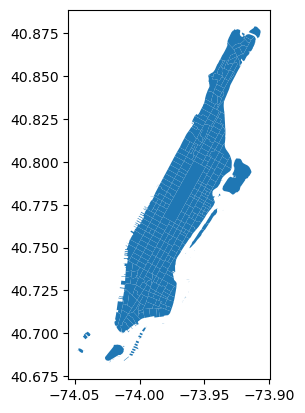

In [7]:
ct.plot()

In [8]:
ct.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### 1.2 Read and Clean Airbnb Listing Data (2 pts)
Similar to homework 1, you are required to download and clean the Airbnb listing data and wrap all of them into one cell. Use the same link in homework 1 to download the listing data in New York City.
- Change *price* column type as float.
- Transform the dataframe into geodataframe using the latitude-longitude pairs.
- Spatial join **ct** with only *geoid*, *boroname* and *the_geom* columns to the listing geodataframe.

You should only have the listings in Manhattan. Present your geodataframe **listing** below.

In [9]:
### Read the zipped csv
listing_raw = pd.read_csv('http://data.insideairbnb.com/united-states/ny/new-york-city/2022-12-04/data/listings.csv.gz')
### Remove dollor sign and tramsform datatype, then show the first 5 rows
listing_raw['price'] = listing_raw['price'].str.replace('$', "").str.replace(',', "").astype(float)
### Generate the GeometryArray
geometry = gpd.points_from_xy(listing_raw['longitude'], listing_raw['latitude'])
### Generate listing_uncleaned and show the first 5 rows
listing_g = gpd.GeoDataFrame(listing_raw, 
                            geometry = geometry,
                            crs='EPSG:4326')
listing_g.head()
### Do the spatial join and show the first 5 rows
listing = gpd.tools.sjoin(ct.loc[:,['geoid','boroname','the_geom']],listing_g,how='inner')
### Show the info
listing.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 17333 entries, 1 to 309
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   geoid                                         17333 non-null  int64   
 1   boroname                                      17333 non-null  object  
 2   the_geom                                      17333 non-null  geometry
 3   index_right                                   17333 non-null  int64   
 4   id                                            17333 non-null  int64   
 5   listing_url                                   17333 non-null  object  
 6   scrape_id                                     17333 non-null  int64   
 7   last_scraped                                  17333 non-null  object  
 8   source                                        17333 non-null  object  
 9   name                                        

### 1.3 Retrieve American Community Survey (ACS) Data (6 pts)
The 3rd dataset is from American Community Survey. You can first check with "2019 ACS Table List" from [ACS table](https://www.census.gov/programs-surveys/acs/technical-documentation/table-shells.2019.html#list-tab-LO1F1MU1CQP3YOHD2T) and find the median household income code as **B19013_001**. Use *cenpy* module to download the household income information in New York City and use census tract level as the geographic unit. Save the data as **acs_data** and name the column for household income as *median_hh_inc*. Present the information of **acs_data**. (2 pts)

In [10]:
## This creates the "connection" to the latest 5-year ACS data in the API, which is 2019
## cenpy.products.ACS(2018) would give us the 2014-2018 ACS data
acs_cp= cenpy.products.ACS()

In [11]:
acs_data = acs_cp.from_place('New York, NY',
                                level='tract',
                                variables=['B19013_001'])

Matched: New York, NY to New York city within layer Incorporated Places


In [12]:
acs_data.head()

,GEOID,geometry,B19013_001E,state,county,tract
0,36085020801,"POLYGON ((-8262278.990 4946228.710, -8261996.3...",100543.0,36,085,020801
1,36085017012,"POLYGON ((-8257822.870 4945745.990, -8257700.4...",89273.0,36,085,017012
2,36085031901,"POLYGON ((-8256173.450 4957701.750, -8256171.1...",21250.0,36,085,031901
3,36085031902,"POLYGON ((-8256709.900 4959461.880, -8256698.5...",46118.0,36,085,031902
4,36085014606,"POLYGON ((-8254594.160 4948740.120, -8254529.4...",103825.0,36,085,014606


In [13]:
### Rename the column
acs_data = acs_data.rename(columns={'B19013_001E':'median_hh_inc'})

In [14]:
acs_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2066 entries, 0 to 2065
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GEOID          2066 non-null   object  
 1   geometry       2066 non-null   geometry
 2   median_hh_inc  2006 non-null   float64 
 3   state          2066 non-null   object  
 4   county         2066 non-null   object  
 5   tract          2066 non-null   object  
dtypes: float64(1), geometry(1), object(4)
memory usage: 113.0+ KB


Notice that *median_hh_inc* column includes null values. Replace all null values with the mean of the median household income. (2 pts)

In [15]:
### Fill the missing data
acs_data['median_hh_inc'] = acs_data['median_hh_inc'].fillna(acs_data['median_hh_inc'].mean())

Plot the median household income by census tract. Five quantiles are used here with *GnBu* color ramp. Remember to add:
- Title
- Legend
- X-Y axis names

properly to the map. (2 pts)

<AxesSubplot: title={'center': '2019 New York City Median Household Income by Census Tract'}, xlabel='Longitude', ylabel='Latitude'>

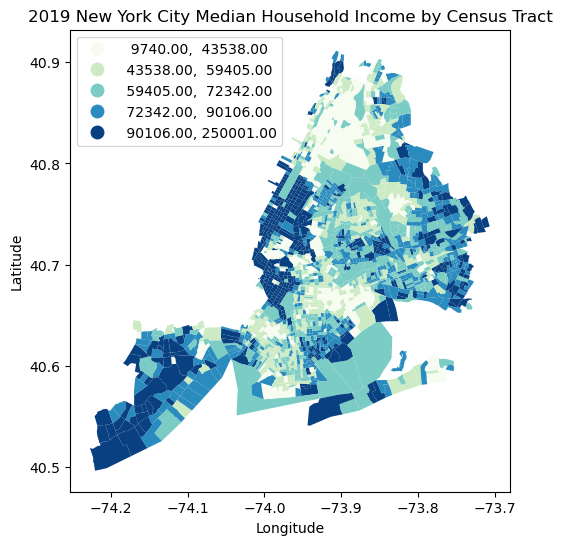

In [16]:
# Plotting the median household income
acs_data = acs_data.to_crs(4326)
fig, ax = plt.subplots(figsize=(6, 6))
plt.title('2019 New York City Median Household Income by Census Tract')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
acs_data.plot(ax=ax,column='median_hh_inc',figsize=(10,10),legend=True,scheme= 'Quantiles',k=5,cmap='GnBu',legend_kwds={'loc': 'upper left'})

## 2. Data Analysis & Visualization
### 2.1 Create Spatial Weights (12 pts)
ACS data is firstly analyzed. Create a spatial weight, *wq*, with *Queen* method and standardize the spatial weight. (2 pts)

In [17]:
# Create spatial weight metrix and standardize it
wq = weights.contiguity.Queen.from_dataframe(acs_data)
wq.transform = "R"

('WARNING: ', 229, ' is an island (no neighbors)')


Since *median_hh_inc* column will be used repetitively, store this column in variable *y*. Therefore, *ylag* is generated from *y* to store the spatial lags of *median_hh_inc*. (2 pts)

In [18]:
# Create y and ylag
acs_data['y'] = acs_data['median_hh_inc']
acs_data['ylag'] = weights.spatial_lag.lag_spatial(wq, acs_data['y'])

To compare *y* with *ylag* visually, you can create two plots side by side. 
- Both maps should have 5 quantiles of *y* and *ylag* respectively with your choice of color ramp. (2 pts)
- Both maps should have proper titles and legends. (2 pts)
- Remove axis for both maps. (2 pts)

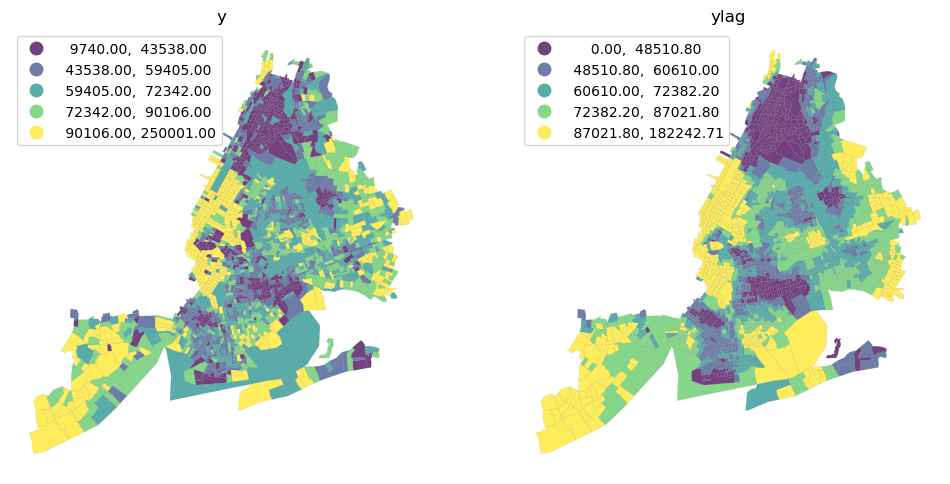

In [19]:
f, axs = plt.subplots(1, 2, figsize=(12, 12))
ax1, ax2 = axs

acs_data.plot(
    cmap="viridis",
    column="y",
    scheme="quantiles",
    k=5,
    edgecolor="grey",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax1,
    legend_kwds={'loc': 'upper left'}
)
ax1.set_axis_off()
ax1.set_title("y")

acs_data.plot(
    cmap="viridis",
    column="ylag",
    scheme="quantiles",
    k=5,
    edgecolor="grey",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax2,
    legend_kwds={'loc': 'upper left'}
)
ax2.set_axis_off()
ax2.set_title("ylag")

plt.show()

Why do the two maps look different? How do you interpret the difference? (2 pts)

Answer: They are different because the right graph is ylag, which is the spatial lag of variable y in the left graph. Here the spatial lag can be seen as a local smoother of the varaible y.

Theoretically, the spatial lag "captures the behavior of a variable in the immediate surroundings of each location". That is to say, if we believe that closer unites have stronger influence to each other, then spatial lag represents the influence on a certain unit given by its surrounding units, and this kind of influence may have effect on how this unit will behave in the next time period (that's why it's called spatial "lag").  The mathematical definition is the product of the spatial weight metrix w and the vector of a given variable.

Since spatial lag tends to reflect 'regional' trends, it's easy to find its graph much smoother than that of the original variable. That's why we call it a 'local smoother'.

### 2.2 Global Spatial Correlation (8 pts)
By plotting median household income above, you will have some ideas about where the affluent and the less affluent people live. To verify your hypothesis, you can try to find how they are correlated with their neighbors globally.

Firstly, create a boolean list *yb* if the census tract's median household income (*y*) exceeds the median median household income in Manhattan (median of *y*). (2 pts)

In [20]:
# Calculate median house income in Manhattan (FIPS = 36 061)
y_median = acs_data[acs_data['county']=='061']['y'].median()

In [21]:
# Create Boolean list
yb = acs_data['y'] > y_median
yb

0        True
1       False
2       False
3       False
4        True
        ...  
2061    False
2062    False
2063    False
2064    False
2065     True
Name: y, Length: 2066, dtype: bool

Next, create a new column *yb* in **acs_data** where *0 low* means the census tract's median household income is below the median of *y* and *1 high* means the rest. (2 pts)

In [22]:
acs_data['yb'] = yb.astype(int)

Plot census tracts whose household income are above the median as black and those below as white. (2 pts)

Text(105.9796514678796, 0.5, 'Latitude')

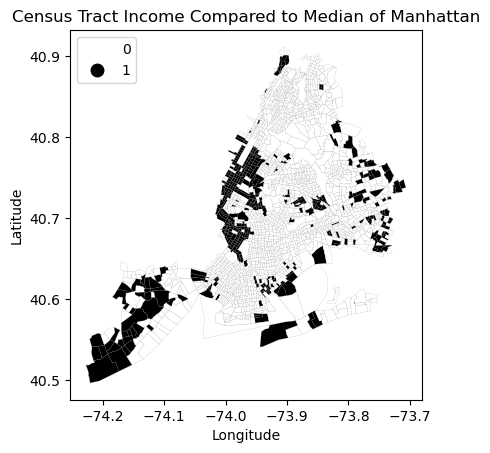

In [23]:
acs_data.plot(
    column='yb',
    legend=True,
    cmap='binary',
    edgecolor="grey",
    categorical=True,
    linewidth=0.1,
    legend_kwds={'loc': 'upper left'},
)
plt.title('Census Tract Income Compared to Median of Manhattan')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Do you think a binary map is better at showing spatial disparity than the quantile map in Q2.1? (2 pts)

Answer: I think a binary map is better when showing the spatial disparity. Since our goal is to highlight the disparity, we should use a way that is bold and easy to understand. A quantile map conveys more information but may be not so clear to show the disparity, since it has a smooth transition and will therefore not highlight the disparity.

### 2.3 Moran's I (8 pts)
By looking at the maps, you are convinced that wealth is not distributed across NYC space evenly. Moran's I will provide you a statistical tool to further testify your hypothesis. 

To create a Moran Plot, you should first calculate the difference between the median household income and its mean. Then repeat the step for the spatial lags of the median household income. Add these two lists to **acs_data** as column *y_std* and *ylag_std*. (2 pts)
Then use seaborn module to make a scatter plot using the two columns. Add x and y axis names and tiles to the plot. (2 pts)

In [24]:
# Calculate the difference between the median household income and its mean
acs_data['y_std'] = (acs_data['y'] - acs_data['y'].mean())

In [25]:
# Calculate the standardized spatial lag
acs_data['ylag_std'] = weights.spatial_lag.lag_spatial(wq, acs_data['y_std'])

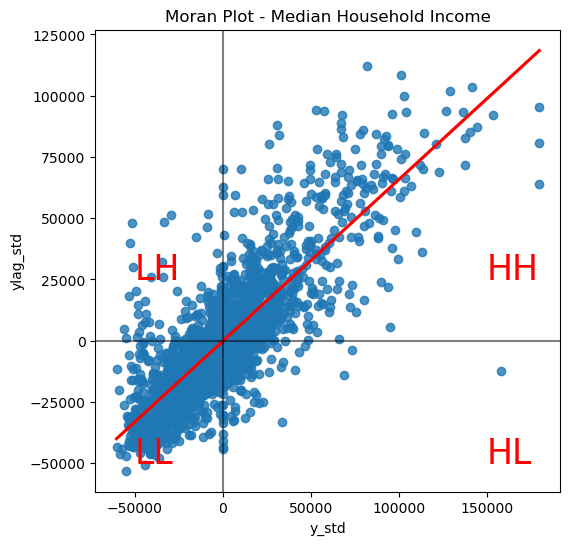

In [26]:
# Make the scatter plot
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x="y_std",
    y="ylag_std",
    ci=None,
    data=acs_data,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - Median Household Income")
plt.text(150000, 25000, "HH", fontsize=25, c="r")
plt.text(150000, -50000, "HL", fontsize=25, c="r")
plt.text(-50000, 25000, "LH", fontsize=25, c="r")
plt.text(-50000, -50000, "LL", fontsize=25, c="r")
plt.show()

How do you interpret the Moran's Plot? Does it indicate a strong or weak autocorrelation? (2 pts)

Answer: This Moran's Plot shows very strong global spatial autocorrelation, which means similar values tend to be located close to each other. The overall trend is for high values to be close to other high values, and for low values to be surrounded by other low values. To interpret this, we can say that tracts which have high median household income tend to be located nearby other tracts with high household median income, and vice versa.

What is the value of your Moran's I? (2 pts)

In [27]:
# Calculate Moran's I
moran = esda.moran.Moran(acs_data['y'], wq)
moran.I

0.6594848030500569

### 2.4 Local Spatial Autocorrelation (8 pts)
The significant value of Moran's I confirms that the spatial distribution of NYC's wealth is highly uneven. But where are the richest neighborhoods and where are the poorest?

Firstly you can generate local Moran's I and name this variable as *li*. (2 pts)

In [28]:
# Generate local Moran's I
li = esda.moran.Moran_Local(acs_data['y'], wq)

Based on the significance value (less than 0.05), create a new column *cl* to **acs_data** with values of *0 ns*, *1 hot pot*, *2 doughnut*, *3 cold spot*, and *4 diamond*. (2 pts)
As the names indicate, Hot Spot is the neighborhoods with high household income and Cold Spot is the neighborhoods with low household income. Doughnut is the low-income neighborhoods surrounded by high-income neighbors while Diamond is the high-income neighborhoods surrounded by low-income neighbors.

In [29]:
# First we assign four situations 1-4 without considering the significance value
acs_data['cl'] = li.q
# Then we change cl of those tracts not significant (p_sim>=0.05) to 0 (ns)
acs_data['cl'][li.p_sim>=0.05] = 0

Plot the four types of census tracts with lightgrey to *0 ns*, red to *1 hot pot*, lightblue to *2 doughnut*, blue to *3 cold spot*, and pink to *4 diamond*. Add legend and titles to the plot. (2 pts)

In [30]:
# Use a list to add the label for each category
acs_data['label'] = 0
acs_data['label'][acs_data['cl']==0] = '0 Non-Significant'
acs_data['label'][acs_data['cl']==1] = '1 Hot Spot'
acs_data['label'][acs_data['cl']==2] = '2 Doughnut'
acs_data['label'][acs_data['cl']==3] = '3 Cold Spot'
acs_data['label'][acs_data['cl']==4] = '4 Diamond'

Text(41.54400877929399, 0.5, 'Latitude')

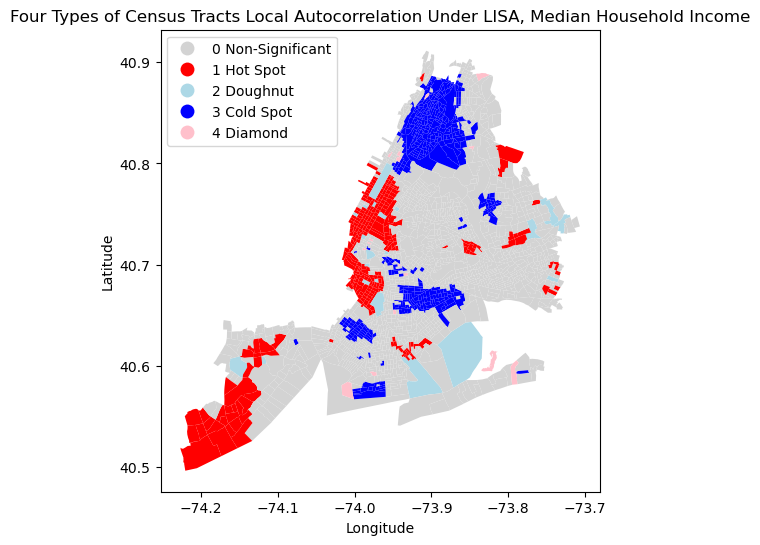

In [31]:
fig1, ax1 = plt.subplots(figsize=(6, 6))
cmap = mpl.colors.ListedColormap(['lightgrey', 'red', 'lightblue','blue', 'pink'])
acs_data.plot(
    column = 'label',
    ax = ax1,
    legend = True,
    cmap=cmap,
    categorical = True,
    legend_kwds={'loc': 'upper left'},
)
plt.title('Four Types of Census Tracts Local Autocorrelation Under LISA, Median Household Income')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

How do you interpret the four types of colored regions under the NYC context? Why do some parks apprear as "doughnuts"? (2 pts)

Answer: The majority of census tracts in NYC has no significant local spatial autocorrelation under LISA analysis. Those tracts appear as 'Non-significant' on the map. However, there are some clusters that tend to show some local spatial autocorrelation patterns. For example, 'Hot Spots' in Manhattan and Staten Island means those tracts and their neighbors all tend to have a higher median household income (HH pattern). As its label 'Hot Spot' indicates, these places are the clusters of the 'richest' neighborhoods. On the contrary, the 'Cold Spots' in the Bronx and Brooklyn are the clusters of LL pattern, which means tracts with median household income lower than average surrounded by tracts of similar situation. Those are the clusters of 'poorest' neighborhoods in the city.

The other two types, 'Doughnut' and 'Diamond', respectively represent low-income tracts surrounded by high-income ones, and high-income tracts surrounded by low-income ones. These negative local spatial autocorrelation patterns emerge beased on local situations. For example, parks can become 'Doughnuts' since it has no (or very low) median household income. And if it is surrounded by some rich neighborhoods, then it becomes a 'Doughnut'.

### 2.5 Point Pattern Analysis (18 pts)
With an image of wealth distribution across NYC, now you can move to the Airbnb listing to see if locations of the short-term rental listing have any relationship with their neighborhoods.

Map all the listing in Manhattan by their coordinates and show the density on latitudes and longitudes respectively. (2 pts)

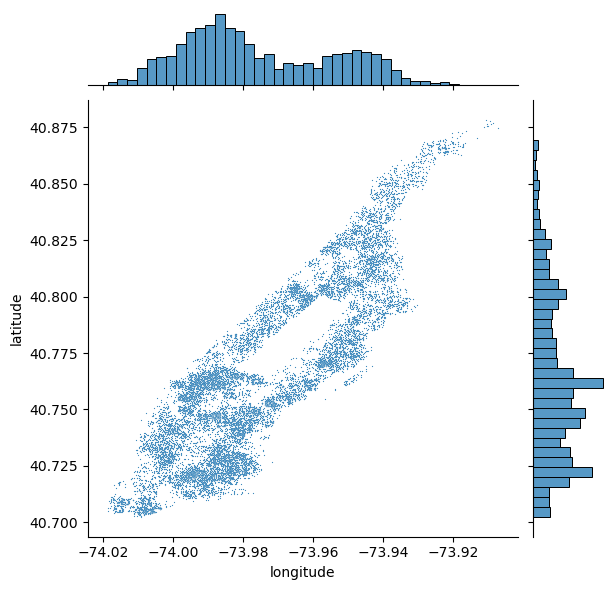

In [32]:
# Generate scatter plot
sns.jointplot(x="longitude", y="latitude", data=listing, s=0.75, height=6)

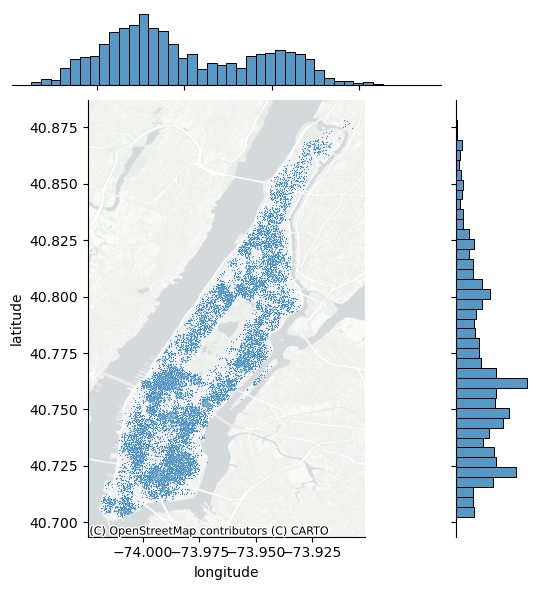

In [33]:
# Generate scatter plot with base map
joint_axes = sns.jointplot(x="longitude", y="latitude", data=listing, s=0.75, height=6)
ctx.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=ctx.providers.CartoDB.PositronNoLabels,
);

To generate a density map for points data, you should firstly assign those points to different areal units. Hexagon is one of the most used units. For Manhattan, you can generate and add hexbin with 50 hexagons in each dimension without bordorline and with half transparency. (2 pts) Add a base map and colorbar and remove axes. (2 pts) Show your map below.

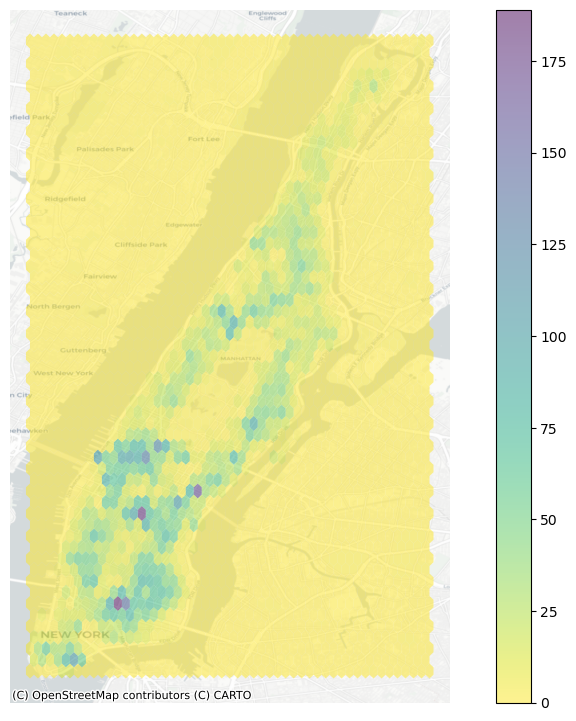

In [34]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))
# Generate and add hexbin with 50 hexagons in each
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
hb = ax.hexbin(
    listing["longitude"],
    listing["latitude"],
    gridsize=50,
    linewidths=0,
    alpha=0.5,
    cmap="viridis_r",
)
# Add basemap
ctx.add_basemap(
    ax, source=ctx.providers.CartoDB.Positron,
    crs="EPSG:4326",
)
# Add colorbar
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()

Find out the mean center (2 pts), median center (2 pts) and standardized ellipse of the Manhattan Airbnb listing. Legend and axis names should be added.

In [35]:
mean_center = centrography.mean_center(listing[["longitude","latitude"]])
med_center = centrography.euclidean_median(listing[["longitude","latitude"]])
major, minor, rotation = centrography.ellipse(listing[["longitude","latitude"]])

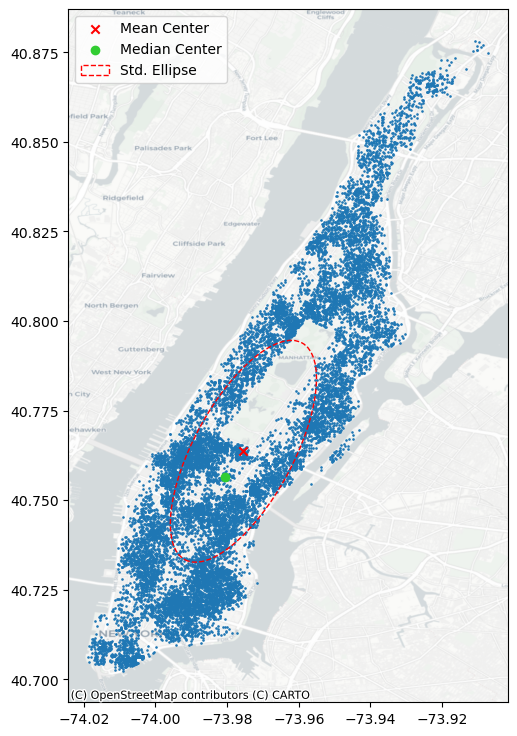

In [36]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot photograph points
ax.scatter(listing["longitude"],listing["latitude"], s=0.75)
ax.scatter(*mean_center, color="red", marker="x", label="Mean Center")
ax.scatter(
    *med_center, color="limegreen", marker="o", label="Median Center"
)

# Construct the standard ellipse using matplotlib
ellipse = Ellipse(
    xy=mean_center,  # center the ellipse on our mean center
    width=major * 2,  # centrography.ellipse only gives half the axis
    height=minor * 2,
    angle=-numpy.degrees(
        rotation
    ),  # Angles for this are in degrees, not radians
    facecolor="none",
    edgecolor="red",
    linestyle="--",
    label="Std. Ellipse",
)
ax.add_patch(ellipse)

ax.legend()
# Display
# Add basemap
ctx.add_basemap(
    ax, source=ctx.providers.CartoDB.Positron,
    crs="EPSG:4326",
)
plt.show()

Why do the mean and median centers differ? (2 pts)

Answer: The discrepancy between the two centers is caused by the skew (or we can say outliners); there are many "clusters" of lower values of pictures far out in uptown Manhattan, whereas downtown and midtown, before the central park, is densely packed, but drops off very quickly. Thus, the far out clusters of pictures pulls the mean center to the north and east, relative to the median center.

Generate a quadrat count map based on the listing. In each quadrat, the number of listings should be shown. (2 pts)

In [37]:
from pointpats import (
    distance_statistics,
    QStatistic,
    random,
    PointPattern,
)

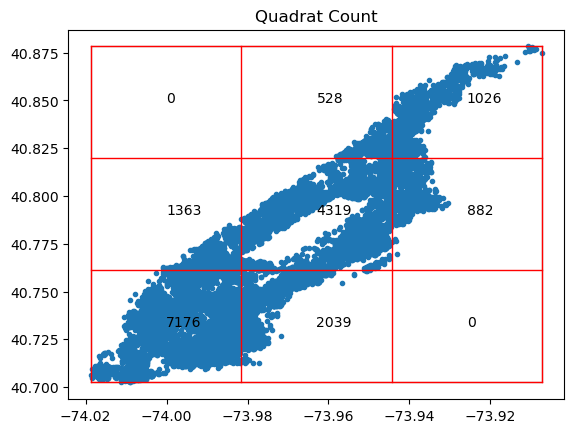

In [38]:
qstat = QStatistic(listing[["longitude","latitude"]].values)
qstat.plot()

From the Quadrat Count figure, which areas have the densest Airbnbs? Provide some hypotheses for why this might be the case. (2 pts)

Answer: Downtown and midtown Manhattan, before the central park, defently has the densest Airbnbs. Some possible hypotheses are:
1.  There are many vistors tend to live close to famous placess which are all gather in downtown and midtown Manhattan.
2. There are multiple public transit options in this area, and tourists tend to choose houses that are most convenient.
3. Comparing to other quadrats, this area has the largest area of land counted.

What is the p-value of a chi-squared test? How do you interpret the value? (2 pts)

In [39]:
qstat.chi2_pvalue

0.0

Answer: A p-value of 0 for a chi-squared test means that the chi-squared test (which compares how likely this distribution is if the cell counts are uniform) will be statistically significant and that the observed data is extremely unlikely under the null hypothesis. This would suggest that there is a very strong association between the variables being studied, and that the null hypothesis can be rejected with a high degree of confidence. 